In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import norm
from torch import optim
from tqdm import tqdm
import torch
import seaborn as sns
import pyro
import numpy.testing as np_testing
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.special import expit, logit
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
sns.set(font_scale=1.5, rc={'figure.figsize':(11.7, 8.27)})
sns.set_style("whitegrid")

# Seminar plan

    0. Reminder of Jensen's inequality  

    1. Fenchel conjacuate for GAN training

    2. Donsker-Varadhaya for Mutual Information estimation


# 0. Jensen's inequality

![](https://f67eb242-a-62cb3a1a-s-sites.googlegroups.com/site/shahriarinia/home/math/probability/Jensen_graph.png?attachauth=ANoY7crN9JHlo_dVKLl1C58mxC6mZBkyxlfNbrNXhmjwOD6J-8XP86hN9y_8aaS_LHEiFCyzErwE_41-Mja7NlOCJZKsPnswRLyl1zKk7HozDa3CdFEa9y4FpfxedhXeX3iTOZesQaXoKbJYyWU6VFmtRXZUIU_83qMjBYr9yZdTI4OjLVwvgcK7cwrD980sEhQaEy43HtsgauSCkn_CABQ1djjMBpZTOtPsxQBQOuufKyqRuBhcHyVA77PGyd-0HIH_5gb0-9v5&attredirects=0)

![](https://people.duke.edu/~ccc14/sta-663/_images/EMAlgorithm_5_0.png)

Given a convex function $f$,
one of the most useful mathematical tools
is *Jensen's inequality*.
It amounts to a generalization of the definition of convexity:

$$\sum_i \alpha_i f(x_i)  \geq f\left(\sum_i \alpha_i x_i\right)    \text{ and }    E_X[f(X)]  \geq f\left(E_X[X]\right),$$

where $\alpha_i$ are nonnegative real numbers such that $\sum_i \alpha_i = 1$ and $X$ is a random variable.
In other words, the expectation of a convex function is no less than the convex function of an expectation, where the latter is usually a simpler expression. 
To prove the first inequality we repeatedly apply the definition of convexity to one term in the sum at a time.


One of the common applications of Jensen's inequality is
to bound a more complicated expression by a simpler one.
For example,
its application can be
with regard to the log-likelihood of partially observed random variables. That is, we use

$$E_{Y \sim P(Y)}[-\log P(X \mid Y)] \geq -\log P(X),$$

since $\int P(Y) P(X \mid Y) dY = P(X)$.
This can be used in variational methods. Here $Y$ is typically the unobserved random variable, $P(Y)$ is the best guess of how it might be distributed, and $P(X)$ is the distribution with $Y$ integrated out. For instance, in clustering $Y$ might be the cluster labels and $P(X \mid Y)$ is the generative model when applying cluster labels.


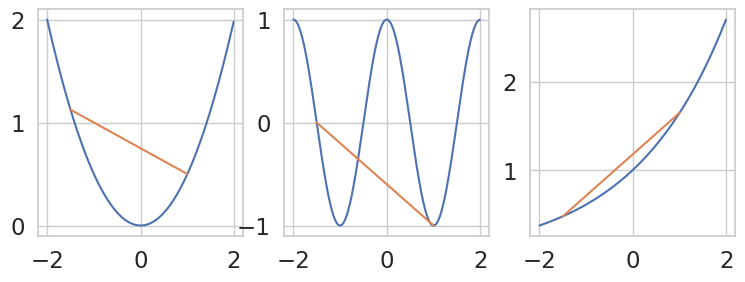

In [2]:
f = lambda x: 0.5 * x**2  # Convex
g = lambda x: torch.cos(np.pi * x)  # Nonconvex
h = lambda x: torch.exp(0.5 * x)  # Convex

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
_, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=100)
for ax, func in zip(*(axes, [f, g, h])):
    ax.plot(x, func(x))
    ax.plot(segment, func(segment))
plt.show()

# 2. Fenchel inequality


https://people.ok.ubc.ca/bauschke/Research/68.pdf

https://modelingsimulation.github.io/TeachingWriting2020/Resources/reports/ShengLiu.pdf

https://handwiki.org/wiki/Convex_conjugate

https://remilepriol.github.io/dualityviz/

# 2.1 Example on KL divergence

https://arxiv.org/pdf/1606.00709.pdf

## 2.2 Fitting 2D-normal distribution


In [3]:
import pyro
from pyro import distributions as distrs
from utils import MixtureDistribution, create_distr, get_parameters, plot_2d_dots, sample

## 2. Target distribution

Target distribution is a mixture of two 2-dimensionals normal distributions.

### 2.1 Data Generation

Here we sampling training data from real distribution:


$$D_{train} = \{x\}_{i=1}^{n} \sim p(x)$$

In [4]:
P1 = create_distr(
    mu=torch.Tensor([-5, -5]), 
    sigma=torch.Tensor([[1., 0.0], 
                        [0.0, 1.]])
)
P2 = create_distr(
    mu=torch.Tensor([4, 3]), 
    sigma=torch.Tensor([[1., 0.0], 
                        [0.0, 1.]])
)

P = MixtureDistribution(P1, P2, 0.5)

samples_x = P.sample(2000)
px = P.log_prob(samples_x).exp()

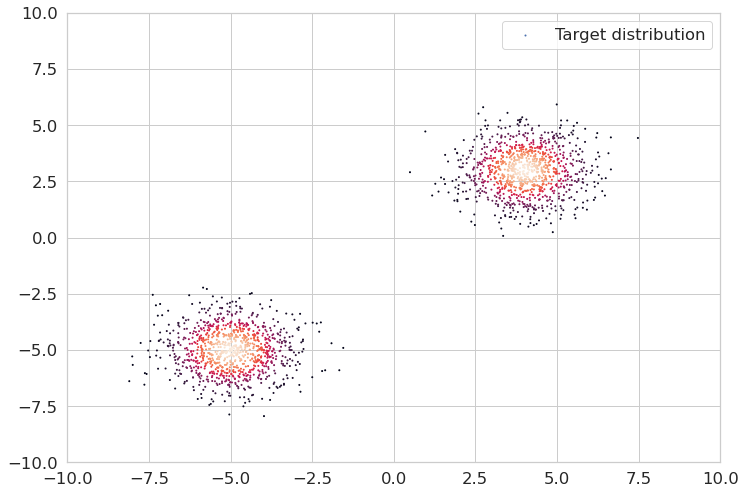

In [5]:
plt.figure()
plot_2d_dots(samples_x, color=px, label='Target distribution')
plt.legend()
plt.show()

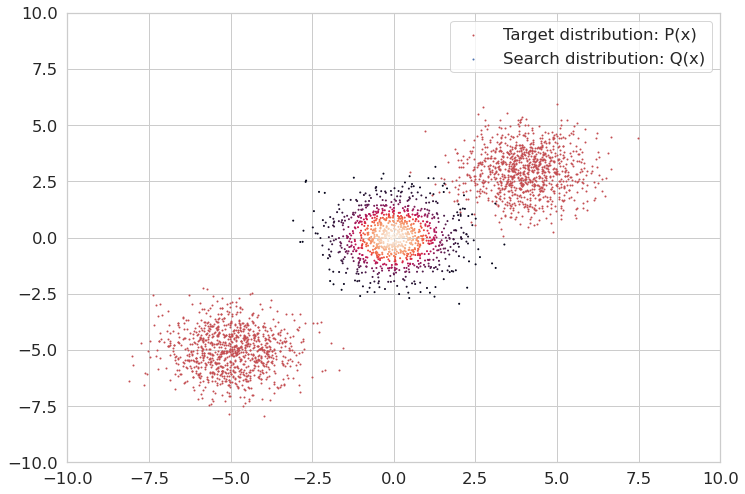

In [6]:
train_mu, train_sigma = get_parameters()

Q = create_distr(train_mu, train_sigma)
samples_q = sample(Q, 1000)
plt.figure()
plot_2d_dots(samples_x, color='r', label='Target distribution: P(x)')
plot_2d_dots(samples_q, color= Q.log_prob(samples_q).exp().detach(), label='Search distribution: Q(x)')

plt.legend()
plt.show()

##### Let's go back to the square one and take a look on 1-dimensional normal distribution

Credits for some parts of code below: http://louistiao.me/notes/a-simple-illustration-of-density-ratio-estimation-and-kl-divergence-estimation-by-probabilistic-classification/

In [7]:
mu_p = torch.tensor(1.)
sigma_p = torch.tensor(1.)

In [8]:
mu_q = torch.tensor(0.)
sigma_q = torch.tensor(2.)

In [9]:
P = distrs.Normal(mu_p, sigma_p)
Q = distrs.Normal(mu_q, sigma_q)

In [10]:
xs = torch.tensor(np.linspace(-5., 5., 500)).float()

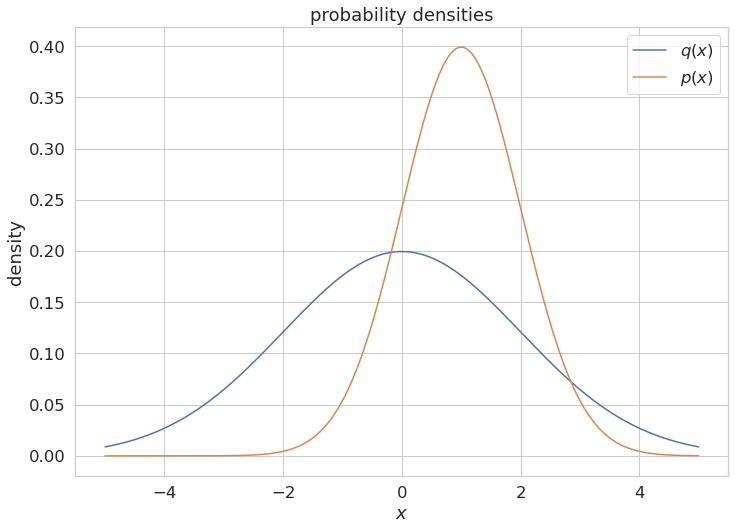

In [11]:
fig, ax = plt.subplots()

ax.set_title('probability densities')

ax.plot(xs, Q.log_prob(xs).exp(), label='$q(x)$')
ax.plot(xs, P.log_prob(xs).exp(), label='$p(x)$')

ax.set_xlim(-5.5, 5.5)

ax.set_xlabel('$x$')
ax.set_ylabel('density')

ax.legend()

plt.show()

## 3.1 Duality

The ratio of their probability densities is given by,

$$
r(x) = \frac{p(x)}{q(x)}.
$$

In [12]:
density_ratio = lambda x, P, Q: P.log_prob(x).exp() / Q.log_prob(x).exp()

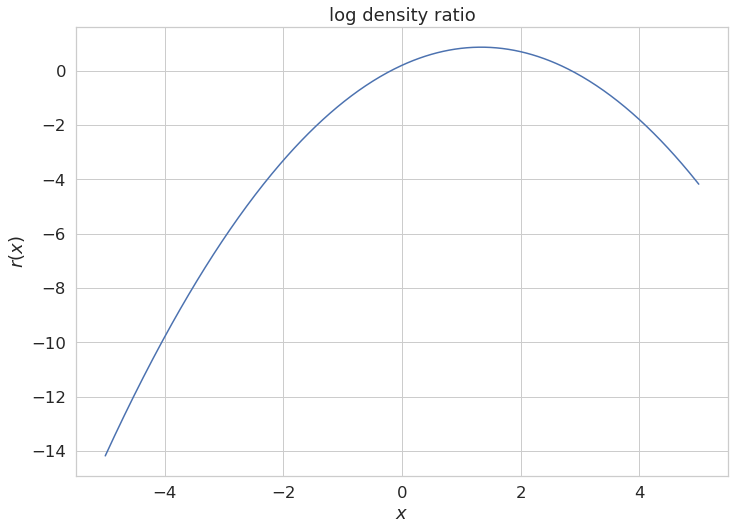

In [13]:
fig, ax = plt.subplots()

ax.set_title('log density ratio')

ax.plot(xs, np.log(density_ratio(xs, P, Q)))

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('$x$')

ax.set_ylabel('$r(x)$')

plt.show()

## 3.2 Density ratio estimation by probabilistic classification


Let $\mathcal{D}_p = \{x_p^{(i)}\}_{i=1}^{n_p}$ and $\mathcal{D}_q = \{x_q^{(j)}\}_{j=1}^{n_q}$ be sets of samples drawn from distributions $p(x)$ and $q(x)$, respectively.

In [14]:
n_p = n_q = 500

In [15]:
samples_p = sample(P, n_p)
samples_q = sample(Q, n_p)

In [16]:
x = torch.cat([samples_p, samples_q]).view(-1, 1)
y = torch.cat([torch.ones_like(samples_p), 
               torch.zeros_like(samples_q)])

In [17]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=.2, random_state=1337
)

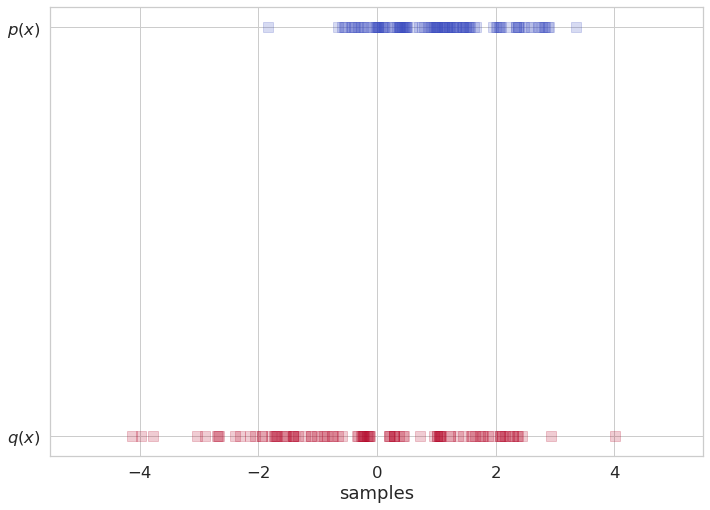

In [18]:
plt.figure()

plt.scatter(x_test, y_test, c=y_test, s=10.**2, 
           marker='s', alpha=.2, cmap='coolwarm_r')

plt.xlim(-5.5, 5.5)

plt.xlabel('samples')
plt.yticks([0, 1], ['$q(x)$', '$p(x)$'])

plt.show()

## 3.3 KL estimation via Bayes optimal classifier

The Bayes optimal classifier can be, __by definition__ written as a function of the density ratio,

$$
p(y=1 \mid x) = \sigma(\log r(x)) = \frac{p(x)}{p(x) + q(x)},
$$

where $\sigma$ is a sigmoid function.

We do not have an access to $p(x)$ and $q(x)$, thus we are building a classifier: $D_{\theta}(x) := \hat{p}(y = 1 \mid x)$. $D_{\theta}(x)$ could be a neural network any other classifier.

Thus, if classifier it well trained then $\hat{p}(y = 1 \mid x) \approx p(y = 1 \mid x)$.

Then ratio density for object $x$ could estimated via the __predicted probability by the trained classifer__ as follows:

$$
\begin{align}
\hat{r}(x)   = \frac{D(x)}{1 - D(x)}
           & = \exp \left ( \log \frac{D(x)}{1 - D(x)} \right ) \\
           & = \exp \left ( \sigma^{-1}(D(x)) \right ). \\
\end{align}                               
$$


### KL as expectation of $r(x)$

$$KL(p || q) = \mathrm{E}_{x \sim p(x)} \sigma^{-1}(D(x))\$$

In [19]:
classifier_optimal = lambda x, p, q: p.log_prob(x).exp() / (p.log_prob(x).exp() + q.log_prob(x).exp())

In [20]:
y_pred_optimal = classifier_optimal(x_test, P, Q)

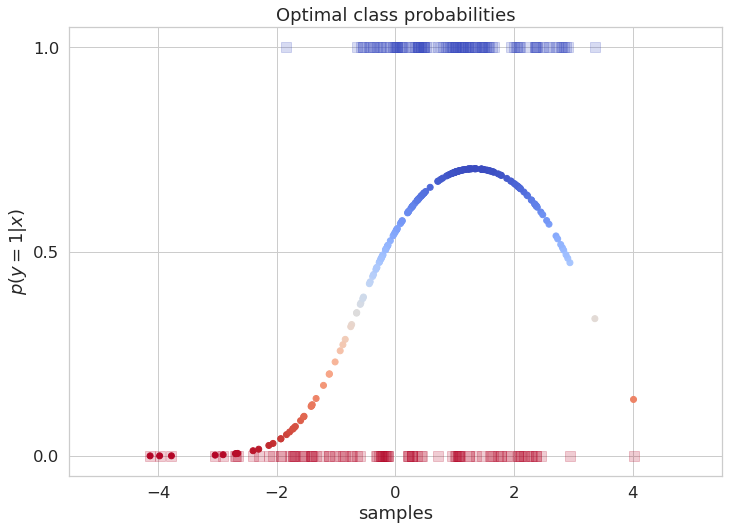

In [21]:
fig, ax = plt.subplots()

ax.set_title('Optimal class probabilities')

ax.scatter(x_test, y_test, c=y_test, s=10.**2, 
           marker='s', alpha=.2, cmap='coolwarm_r')

ax.scatter(x_test, y_pred_optimal, c=y_pred_optimal, cmap='coolwarm_r')

ax.set_xlim(-5.5, 5.5)
ax.set_xlabel('samples')

ax.set_yticks([0., .5, 1.])
ax.set_ylabel('$p(y=1|x)$')

plt.show()

## Fenchel conjacuate for deriving lower bound on KL

Based on: https://arxiv.org/pdf/1606.00709.pdf


$$D_f (P||Q) = \int_{R^n} q(x) f \left( \frac{p(x)}{q(x)}\right) dx$$

For KL: $f(u) = u \log u$

Fenchel conacuate:
$$f^*(t) = \sup_u ut - f(u)$$

If $f$ is convex:

$$f(u) = f^{**}(u) = \sup_t ut - f^*(t)$$

Then:

$$D_f (P||Q) = \int_{R^n} q(x) f \left( \frac{p(x)}{q(x)}\right) dx = \int_{R^n} q(x) \sup_t \left( t \frac{p(x)}{q(x)} - f^*(t) \right) dx $$

Let's substitute $t$ with some function of $x$, i.e. $t = T(x)$. Because it is a (random) substitution we will not reach suprerum, thus:


$$ D_f (P||Q) \geq \sup_{T(x)} \int_{R^n} q(x) \left( T(x) \frac{p(x)}{q(x)} - f^*(T(x)) \right) dx  = $$


$$ = \sup_{T(x)} \left( \mathrm{E}_{p(x)} T(x) -  \mathrm{E}_{q(x)} f^*(T(x)) \right)$$

![](f_star_fenchel.png)

In [22]:
from torch import nn
critic = nn.Sequential(
    nn.Linear(1, 16),
    nn.Tanh(),
    nn.Linear(16, 16),
    nn.Tanh(),
    nn.Linear(16, 1),
)

In [23]:
def fenchel_kl_loss(x, y, critic):
    preds = critic(x)
    return preds[y == 1].mean() - (preds[y == 0] - 1).exp().mean()

In [24]:
from collections import defaultdict

epochs = 200

optim = torch.optim.Adam(critic.parameters(), lr=1e-2)
ce = torch.nn.BCELoss()

hist = defaultdict(list)

for i in tqdm(range(epochs)):
    optim.zero_grad()
    loss = -fenchel_kl_loss(x_train, y_train, critic)
    loss_test = -fenchel_kl_loss(x_test, y_test, critic)
    hist['loss_train'].append(loss.item())
    hist['loss_test'].append(loss_test.item())
    loss.backward()
    optim.step()

100%|██████████| 200/200 [00:01<00:00, 167.98it/s]


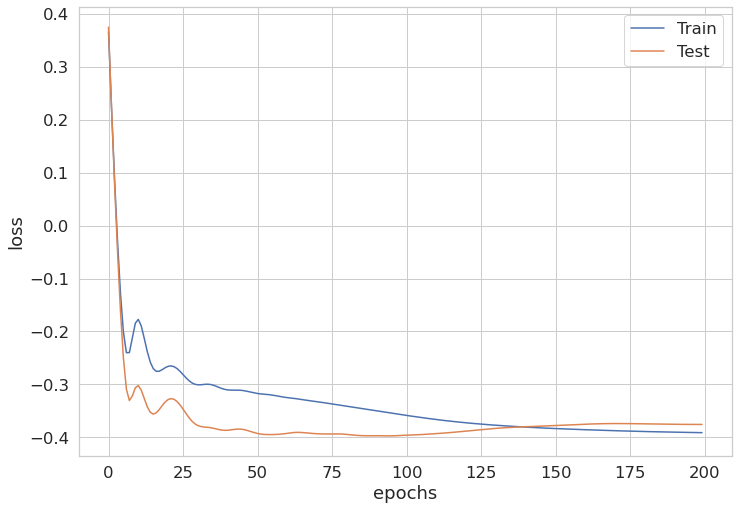

In [25]:
fig, ax = plt.subplots()

plt.plot(hist['loss_train'], label='Train')
plt.plot(hist['loss_test'], label='Test')

ax.set_ylabel('loss')
ax.set_xlabel('epochs')
plt.legend()

plt.show()

## 3.5 KL divergence estimation

A natural application of density ratio estimation is divergence estimation. Namely, approximating a divergence from the general family of $f$-divergences using only samples. Here, we will approximate the Kullback-Liebler (KL) divergence between $P$ and $Q$ without using their respective densities, $p(x)$ and $q(x)$.

In [26]:
mc_samples = 5000

In [27]:
samples_p = sample(P, mc_samples)
samples_q = sample(Q, mc_samples)
x = torch.cat([samples_p, samples_q]).view(-1, 1)
y = torch.cat([torch.ones_like(samples_p), 
               torch.zeros_like(samples_q)])
idx = torch.randperm(len(x))
x = x[idx]
y = y[idx]

In [28]:
kl_mc = pd.Series(density_ratio(samples_p, P, Q).log())

In [29]:
kl_fenchel = [fenchel_kl_loss(x[:i], y[:i], critic).item() for i in range(1, len(x))]
kl_fenchel = pd.Series(kl_fenchel)

In [30]:
kl_estimates = pd.concat([kl_mc, kl_fenchel], axis=1, 
                         keys=['kl_mc', 'kl_fenchel'])
kl_estimates.describe()

kl_mc   kl_fenchel
count  5000.000000  9998.000000
mean      0.436002     0.397681
std       0.586656     0.046373
min      -4.424010     0.346838
25%       0.290895     0.388045
50%       0.662586     0.392996
75%       0.816862     0.404712
max       0.859814     1.648229

#### KL divergence between Gaussians

For Gaussian distributions, the KL divergence can be evaluated analytically as,

$$
\log \sigma_q - \log \sigma_p - \frac{1}{2} 
    \left \{ 1 - \left (\frac{\sigma_p^2 + (\mu_p - \mu_q)^2}{\sigma_q^2} \right ) \right \}.
$$

In [31]:
def kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q):
    r = mu_p - mu_q
    return (np.log(sigma_q) - np.log(sigma_p) - .5 * (1. - (sigma_p**2 + r**2) / sigma_q**2))

In [32]:
kl_analytical = kl_divergence_gaussians(mu_p, sigma_p, mu_q, sigma_q)
kl_analytical

tensor(0.4431)

/root/miniconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/root/miniconda/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


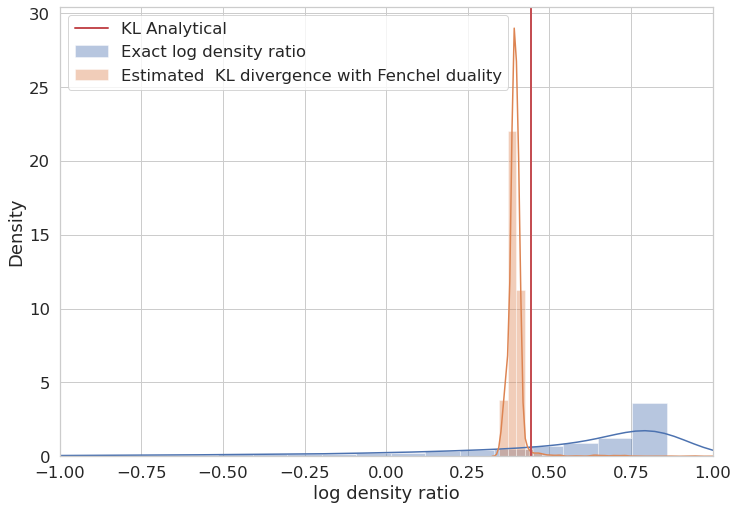

In [33]:
fig, ax = plt.subplots()

sns.distplot(kl_estimates.kl_mc, ax=ax, label='Exact log density ratio')
sns.distplot(kl_estimates.kl_fenchel, ax=ax,  
             label='Estimated  KL divergence with Fenchel duality')

ax.axvline(x=kl_analytical, color='r', linewidth=2., 
           label='KL Analytical')

ax.set_xlim(-1, 1)
ax.set_xlabel('log density ratio')

ax.legend()

plt.show()

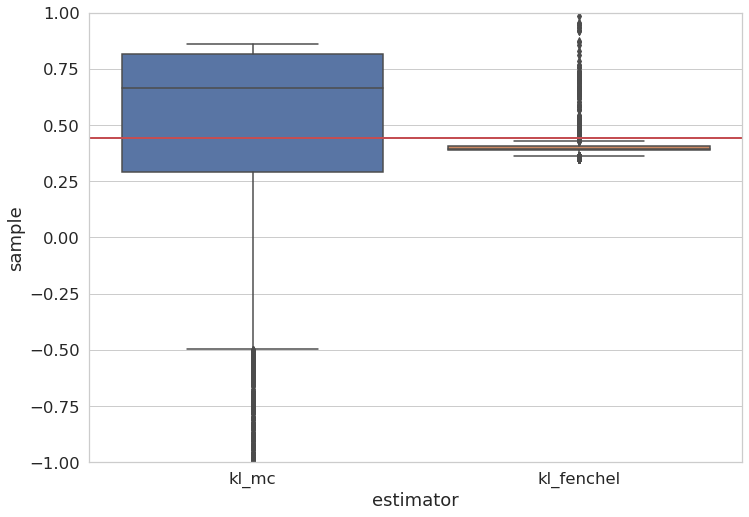

In [34]:
fig, ax = plt.subplots()

sns.boxplot(x='estimator', y='sample',
            data=pd.melt(kl_estimates, 
                         var_name='estimator', 
                         value_name='sample'), ax=ax)

ax.axhline(y=kl_analytical, color='r', linewidth=2., 
           label='Analytical')

ax.set_ylim(-1, 1)

plt.show()

In [35]:
# Cumulative mean of MC samples
kl_estimates_cum_mean = kl_estimates.expanding().mean()

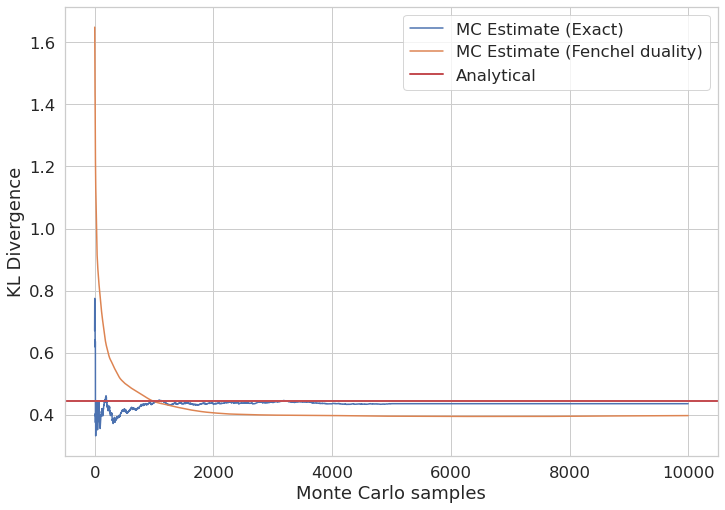

In [36]:
fig, ax = plt.subplots()

kl_estimates_cum_mean.plot(ax=ax, y='kl_mc', 
                           label='MC Estimate (Exact)')

kl_estimates_cum_mean.plot(ax=ax, y='kl_fenchel', 
                           label='MC Estimate (Fenchel duality)', )

ax.axhline(y=kl_analytical, color='r', linewidth=2., 
           label='Analytical')

ax.set_xlabel('Monte Carlo samples')
ax.set_ylabel('KL Divergence')

ax.legend()

plt.show()

# 4. Fenchel and rKL optimization

In [37]:
P1 = create_distr(
    mu=torch.Tensor([-5, -5]), 
    sigma=torch.Tensor([[1., 0.0], 
                        [0.0, 1.]])
)
P2 = create_distr(
    mu=torch.Tensor([4, 3]), 
    sigma=torch.Tensor([[1., 0.0], 
                        [0.0, 1.]])
)

P = MixtureDistribution(P1, P2, 0.5)

samples_p = P.sample(2000)
px = P.log_prob(samples_x).exp()

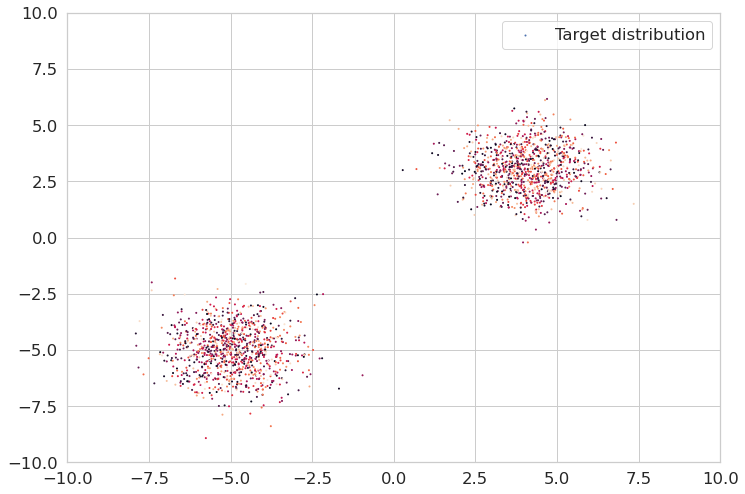

In [38]:
plt.figure()
plot_2d_dots(samples_p, color=px, label='Target distribution')
plt.legend()
plt.show()

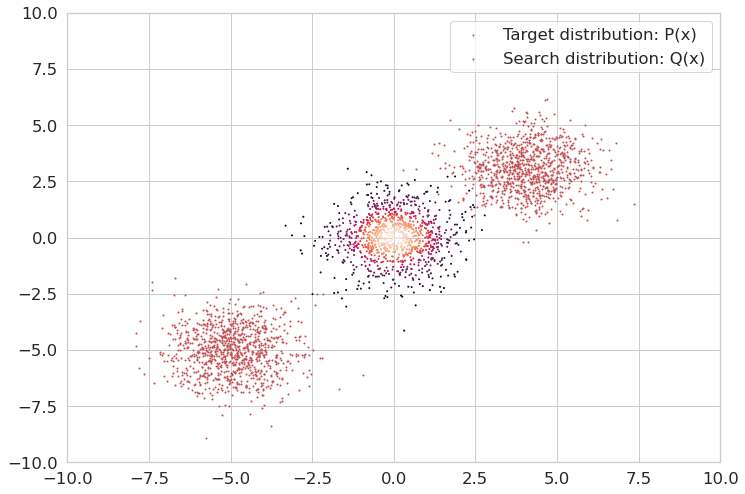

In [39]:
train_mu, train_sigma = get_parameters()

Q = create_distr(train_mu, train_sigma)
samples_q = sample(Q, 1000)
plt.figure()
plot_2d_dots(samples_p, color='r', label='Target distribution: P(x)')
plot_2d_dots(samples_q.detach(), color= Q.log_prob(samples_q).exp().detach(), label='Search distribution: Q(x)')

plt.legend()
plt.show()

In [40]:
def fenchel_rkl_loss(x, y, critic):
    preds = - (- critic(x)).exp()
    return preds[y == 1].mean() - (- 1 - (-preds[y == 0]).log()).mean()

In [41]:
def sample(d, num):
    """
    Sample from distribution num samples with __Pyro__
    """
    res = pyro.sample("dist", d.expand([num]))
    return res

In [42]:
def create_critic(x, y, input_dim=2, epochs=50):
    """
    This function create and train critic network with weights clipping
    """
    critic = nn.Sequential(
        nn.Linear(input_dim, 32),
        nn.Tanh(),
        nn.Linear(32, 32),
        nn.Tanh(),
        nn.Linear(32, 1),
    )
    critic_optim = torch.optim.Adam(critic.parameters(), lr=1e-3)
    ce = torch.nn.BCELoss()
    for _ in range(epochs):
        critic_optim.zero_grad()
        loss = -fenchel_rkl_loss(x, y, critic)
        loss.backward()
        critic_optim.step()
    return critic

### Estimate Reverse KL Divergence

\begin{equation*}
 KL ( q_{\theta}||p  ) = \int_{R^n}q_{\theta}(x)\log\left( \frac{q_{\theta}(x)}{p(x)}\right) dx. 
\end{equation*}

So now I am interested in $r_{reverse} = \frac{q(x)}{p(x)}$.

To estimate it, we need sligtly modify formula from above:


$$
\begin{align}
\hat{r}_{reverse}(x) = \exp \left ( \sigma^{-1}(1 - D(x)) \right ). \\
\end{align}                               
$$



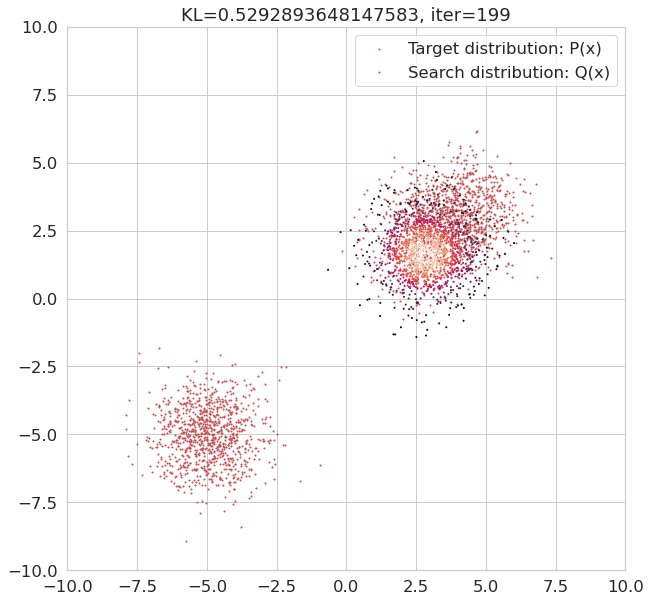

In [44]:
train_mu, train_sigma = get_parameters(mu=0.0, sigma=1.)
train_sigma = train_sigma.requires_grad_(False)

optim = torch.optim.SGD([train_mu, train_sigma], lr=2.)

for i in range(200):
    
    Q = create_distr(train_mu, train_sigma)
    samples_q = sample(Q, n_q).detach()
    x = torch.cat([samples_p, samples_q])
    y = torch.cat([torch.ones(len(samples_p)), 
                   torch.zeros(len(samples_q))])
    critic = create_critic(x, y)
    
    samples_q = sample(Q, n_q)
    x = torch.cat([samples_p, samples_q])
    y = torch.cat([torch.ones(len(samples_p)), 
                   torch.zeros(len(samples_q))])
    optim.zero_grad()
    loss = fenchel_rkl_loss(x, y, critic)
    loss.backward()
    
    optim.step()
    if i % 1 == 0:
        # plot pdfs
        clear_output(True)
        plt.figure(figsize=(10, 10))
        plt.title(f'KL={loss.item()}, iter={i}')
        plot_2d_dots(x.detach().numpy(), color='r', label='Target distribution: P(x)')
        samples_q = sample(Q, 1000)
        plot_2d_dots(samples_q.detach(), color=Q.log_prob(samples_q).exp().detach(), label='Search distribution: Q(x)')
        plt.legend()
        plt.show()

# 3. Donsker inequality


$$D_{KL} = \sup_{T} \mathrm{E}_{p(x)} T(x) - \log \left[ \mathrm{E}_{q(x)} \exp(T(x)) \right]$$ 


## 3.1 Mutual information

Mutual information measures the dependence betweeen X and Y, or, the information about X provided by Y.

$$I(X, Y) = \mathrm{H}(X) + \mathrm{H}(Y) - \mathrm{H}(X, Y) = \mathrm{H}(X) - \mathrm{H}(X | Y)$$


Anoter way to compute mutual information: 

$$I(P, Q) = KL(p(x, y) | p(x) p(y))$$

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from scipy.stats import norm
from torch import optim
from tqdm import tqdm
import torch
import seaborn as sns
import pyro
import numpy.testing as np_testing
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from scipy.special import expit, logit
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
sns.set(font_scale=1.5, rc={'figure.figsize':(11.7, 8.27)})
sns.set_style("whitegrid")

In [46]:
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

An implementation of a Mutual Information estimator with a deep model.

    Three different toy data-sets are implemented, each consists of
    pairs of samples, that may be from different spaces:

    (1) Two MNIST images of same class. 

    (2) One MNIST image and a pair of real numbers whose difference is
    the class of the image. 

    (3) Two 1d sequences, the first with a single peak, the second with
    two peaks, and the height of the peak in the first is the
    difference of timing of the peaks in the second. 

In [47]:
from utils import load_minst

In [48]:
used_MNIST_classes = torch.tensor([0, 1, 2], device="cpu")

In [49]:
train_input, train_target, test_input, test_target = load_minst(used_MNIST_classes, "cpu")

/root/miniconda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/root/miniconda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/root/miniconda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/root/miniconda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [50]:
from utils import create_image_pairs, create_image_values_pairs, create_sequences_pairs
from utils import NetForImagePair, NetForImageValuesPair, NetForSequencePair
from utils import entropy
import utils
utils.used_MNIST_classes = used_MNIST_classes
utils.INDEPENDENT = False
utils.train_input = train_input
utils.train_target = train_target
utils.test_input = test_input
utils.test_target = test_target
utils.nb_classes = 3
utils.device = device

![](peaks_entropy.png)

In [56]:
create_pairs = create_image_pairs
model = NetForImagePair()

# create_pairs = create_image_values_pairs
# model = NetForImageValuesPair()

#  create_pairs = create_sequences_pairs
# model = NetForSequencePair()

In [57]:
learning_rate = 1e-3
batch_size = 256
epochs = 20

In [58]:
print(f'nb_parameters {sum(x.numel() for x in model.parameters())}')
model.to(device)
input_a, input_b, classes = create_pairs(train=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

nb_parameters 78097


In [59]:
import math
import sys

for e in range(epochs):
    input_br = input_b[torch.randperm(input_b.size(0))] # p(x, y) -> p(x) p(y)
    acc_mi = 0.0
    for batch_a, batch_b, batch_br in zip(input_a.split(batch_size),
                                          input_b.split(batch_size),
                                          input_br.split(batch_size)):
        batch_a, batch_b, batch_br = batch_a.to(device), batch_b.to(device), batch_br.to(device)
        mi = model(batch_a, batch_b).mean() - model(batch_a, batch_br).exp().mean().log()
        acc_mi += mi.item()
        loss = - mi
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    acc_mi /= (input_a.size(0) // batch_size)
    print(f'{e+1} {acc_mi / math.log(2):.04f}')
    sys.stdout.flush()

input_a, input_b, classes = create_pairs(train=False)
input_br = input_b[torch.randperm(input_b.size(0))]
acc_mi = 0.0

for batch_a, batch_b, batch_br in zip(input_a.split(batch_size),
                                      input_b.split(batch_size),
                                      input_br.split(batch_size)):
    batch_a, batch_b, batch_br = batch_a.to(device), batch_b.to(device), batch_br.to(device)
    mi = model(batch_a, batch_b).mean() - model(batch_a, batch_br).exp().mean().log()
    acc_mi += mi.item()

acc_mi /= (input_a.size(0) // batch_size)

print(f'test {acc_mi / math.log(2):.04f}')

1 0.5311
2 1.1860
3 1.3375
4 1.3580
5 1.3798
6 1.4853
7 1.4855
8 1.4740
9 1.4948
10 1.5105
11 1.5043
12 1.5213
13 1.5306
14 1.5520
15 1.5516
16 1.5273
17 1.5966
18 1.5370
19 1.5460
20 1.5535
test 1.9013
